<a href="https://colab.research.google.com/github/adag21044/news-sentiment-analysis/blob/main/news_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler  # Azınlık sınıfı artırmak için

In [59]:
pip install requests beautifulsoup4 pandas scikit-learn matplotlib


In [60]:
# NLTK stopwords indir
nltk.download("stopwords")
from nltk.corpus import stopwords
turkish_stopwords = stopwords.words("turkish")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def scrape_news(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        return [h.text.strip() for h in soup.find_all("h3") if h.text.strip() != ""]
    return []

# ✅ Daha fazla haber kaynağı ekledik
mynet_news = scrape_news("https://www.mynet.com/haber")
ntv_news = scrape_news("https://www.ntv.com.tr/gundem")
hurriyet_news = scrape_news("https://www.hurriyet.com.tr/gundem/")
haberturk_news = scrape_news("https://www.haberturk.com/")
cnn_news = scrape_news("https://www.cnnturk.com/turkiye")
bbc_news = scrape_news("https://www.bbc.com/turkce")

# ✅ Tüm haberleri birleştirelim
titles = mynet_news + ntv_news + hurriyet_news + haberturk_news + cnn_news + bbc_news
df = pd.DataFrame(titles, columns=["comment"])

print(f"\n✅ **Toplam çekilen haber sayısı: {len(df)}**")



✅ **Toplam çekilen haber sayısı: 102**


In [62]:
print(f"\n✅ Toplam çekilen haber sayısı: {len(df)}")



✅ Toplam çekilen haber sayısı: 102


In [64]:
# ✅ 2. Veri Temizleme Fonksiyonu
def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    return text

df["clean_comment"] = df["comment"].apply(preprocess)

In [65]:
# ✅ 3. Gelişmiş Duygu Etiketleme
def label_sentiment(text):
    negative_words = ["felaket", "ölüm", "kötü", "kriz", "çöküş", "patlama", "deprem", "saldırı", "ölü", "yıkım", "yangın", "acı"]
    positive_words = ["müjde", "başarı", "kurtuluş", "kazanç", "büyüme", "iyi", "mutlu", "sevindirici", "zafer", "güzel"]

    neg_count = sum(1 for word in negative_words if word in text)
    pos_count = sum(1 for word in positive_words if word in text)

    if neg_count > pos_count:
        return "negative"
    elif pos_count > neg_count:
        return "positive"
    else:
        return "neutral"

df["sentiment"] = df["clean_comment"].apply(label_sentiment)

print("\n✅ **Sınıf Dağılımı:**")
print(df["sentiment"].value_counts())


✅ **Sınıf Dağılımı:**
sentiment
neutral     88
positive     8
negative     6
Name: count, dtype: int64


In [66]:
# ✅ 4. TF-IDF ile Vektörleştirme (max_features=200)
vectorizer = TfidfVectorizer(stop_words=turkish_stopwords, max_features=200)
X = vectorizer.fit_transform(df["clean_comment"])
y = df["sentiment"]

In [67]:
# ✅ 5. **SMOTE Yerine Random Oversampling Kullan**
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_res, y_res = ros.fit_resample(X, y)  # Negative örnekleri artırır

In [68]:
# ✅ 6. Eğitim-Test Bölmesi
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res, shuffle=True
)

In [69]:
# ✅ 7. Naive Bayes Modeli
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)


In [70]:
# ✅ 8. Logistic Regression Modeli
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)


In [71]:
# ✅ 9. Model Skorları
print(f"\nNaive Bayes Accuracy: {accuracy_score(y_test, nb_pred):.2f}")
print(classification_report(y_test, nb_pred))

print(f"\nLogistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.2f}")
print(classification_report(y_test, lr_pred))


Naive Bayes Accuracy: 0.83
              precision    recall  f1-score   support

    negative       0.77      1.00      0.87        17
     neutral       1.00      0.61      0.76        18
    positive       0.80      0.89      0.84        18

    accuracy                           0.83        53
   macro avg       0.86      0.83      0.82        53
weighted avg       0.86      0.83      0.82        53


Logistic Regression Accuracy: 0.94
              precision    recall  f1-score   support

    negative       0.94      1.00      0.97        17
     neutral       0.89      0.94      0.92        18
    positive       1.00      0.89      0.94        18

    accuracy                           0.94        53
   macro avg       0.95      0.94      0.94        53
weighted avg       0.95      0.94      0.94        53



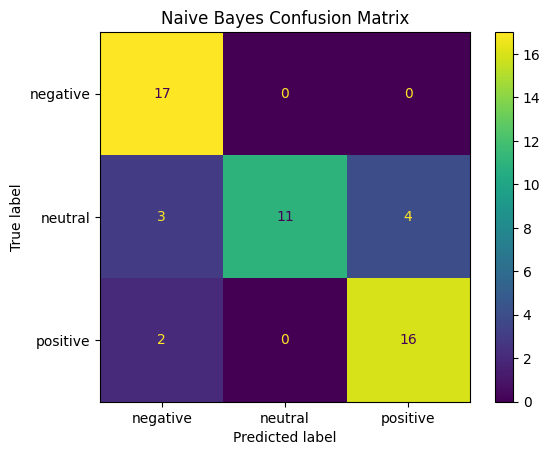

In [72]:
# ✅ 10. Confusion Matrix – NB
cm = confusion_matrix(y_test, nb_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot()
plt.title("Naive Bayes Confusion Matrix")
plt.show()

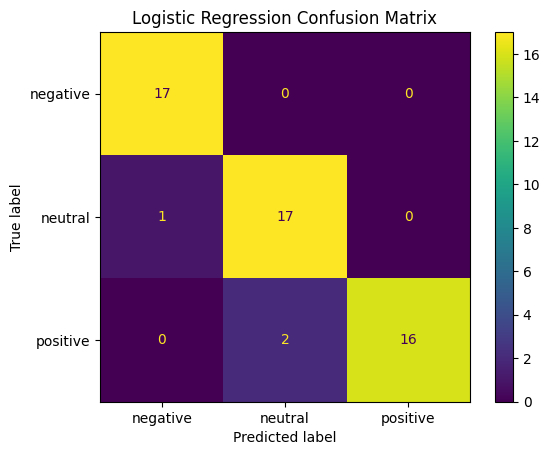

In [73]:
# ✅ 11. Confusion Matrix – LR
cm = confusion_matrix(y_test, lr_pred, labels=lr_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [74]:
# ✅ 12. CSV Kaydet
df.to_csv("mynet_news_sentiment.csv", index=False, encoding="utf-8")
print("\n✅ CSV kaydedildi: mynet_news_sentiment.csv")
print(df.head())


✅ CSV kaydedildi: mynet_news_sentiment.csv
                                            comment  \
0  Film sahnesini aratmadı: Firari böyle yakalandı!   
1     İBB Meclisi 24 Mart'ta olağanüstü toplanacak!   
2             İsmail Saymaz'la ilgili yeni gelişme!   
3                   Ege Denizi'nde korkutan deprem!   
4              Rusya'dan Ekrem İmamoğlu açıklaması!   

                                    clean_comment sentiment  
0  film sahnesini aratmadı firari böyle yakalandı   neutral  
1      i̇bb meclisi  martta olağanüstü toplanacak   neutral  
2            i̇smail saymazla ilgili yeni gelişme   neutral  
3                   ege denizinde korkutan deprem  negative  
4             rusyadan ekrem i̇mamoğlu açıklaması   neutral  
